<a href="https://colab.research.google.com/github/FurrukhJamal/ColabML/blob/main/mnist_fashion_using_custom_training_loop.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

Book's chapter 12 Question 12, Building a custom layer


In [ ]:
import sys
assert sys.version_info >= (3, 7)

In [ ]:
from packaging import version
import tensorflow as tf

assert version.parse(tf.__version__) >= version.parse("2.8.0")

In [ ]:
class LayerNormalization(tf.keras.layers.Layer):
  def __init__(self , epsilon = 0.001, **kwargs):
    super().__init__(**kwargs)
    self.epsilon = epsilon


  def build(self, batch_input_shape):
    self.alpha = self.add_weight(
        name = "alpha",
        shape = batch_input_shape[-1:],
        initializer = tf.keras.initializers.Ones(), # can also write just "ones"
        dtype = self.dtype
    )

    self.beta = self.add_weight(
        name = "beta",
        shape = batch_input_shape[-1:],
        initializer = tf.keras.initializers.Zeros(), # can also write "zeros"
        dtype = tf.float32
    )

  def call(self, X):
    # note : variance = (standard deviation)**2 and symbol for variance is sigma squared
    mean , variance = tf.nn.moments(X, axes = -1 , keepdims = True)
    std = tf.math.sqrt(variance)
    return self.alpha *  (X - mean)/(std + self.epsilon) + self.beta


checking if it produces the same output as tf.keras.layers.LayerNormalization.


In [ ]:
x = tf.Variable([[1, 2, 3], [3,4,5]] ,dtype = tf.float32)
x.shape

TensorShape([2, 3])

In [ ]:
x

<tf.Variable 'Variable:0' shape=(2, 3) dtype=float32, numpy=
array([[1., 2., 3.],
       [3., 4., 5.]], dtype=float32)>

In [ ]:
tf.rank(x)

<tf.Tensor: shape=(), dtype=int32, numpy=2>

In [ ]:
output = tf.keras.layers.LayerNormalization()(x)
print(f"output from tf : {output}")

output = LayerNormalization()(x)
print(f"output from my Layer : {output}")

output from tf : [[-1.2238274  0.         1.2238274]
 [-1.2238274  0.         1.2238274]]
output from my Layer : [[-1.2232467  0.         1.2232467]
 [-1.2232467  0.         1.2232467]]


Q13 Train model using custom training loop to tackle the Fashion MNIST

In [ ]:
(xTrain, yTrain), (xTest, yTest) = tf.keras.datasets.fashion_mnist.load_data()
xTrain.shape

(60000, 28, 28)

In [ ]:
# xTrain = tf.cast(xTrain, tf.float32)/255
# xTest = tf.cast(xTest, tf.float32)/255

In [ ]:
xTrain = xTrain/255.0
xTest = xTest/255.0

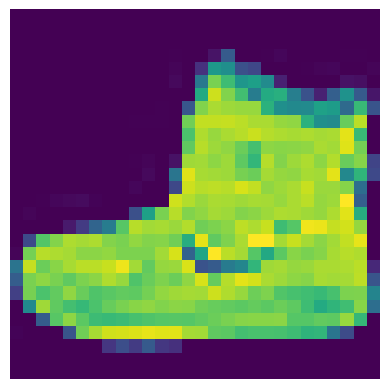

In [ ]:
import matplotlib.pyplot as plt
plt.axis('off')
plt.imshow(xTrain[0])

This is how the model would be trained using the simple sequence_API.

In [ ]:
tf.keras.utils.set_random_seed(42)
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28 , 28]),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(300, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "softmax")
])

model.compile(optimizer = "SGD", loss = "sparse_categorical_crossentropy", metrics = ["accuracy"])
model.fit(xTrain, yTrain, epochs = 20)

loss, accuracy = model.evaluate(xTest, yTest)
print(f"loss : {loss}, accuracy : {accuracy}")

Epoch 1/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.6373 - loss: 1.1102
Epoch 2/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8198 - loss: 0.5204
Epoch 3/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8388 - loss: 0.4648
Epoch 4/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8492 - loss: 0.4343
Epoch 5/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8553 - loss: 0.4132
Epoch 6/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8613 - loss: 0.3969
Epoch 7/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 11s 4ms/step - accuracy: 0.8653 - loss: 0.3831
Epoch 8/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 10s 4ms/step - accuracy: 0.8694 - loss: 0.3711
Epoch 9/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 9s 3ms/step - accuracy: 0.8721 - loss: 0.3605
Epoch 10/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 7s 4ms/step - accuracy: 0.8754 - loss: 0.3508
Epoch 11/20
1875/1875 ━━━━━━━━━━━━━━━━━━━━ 6s 3ms/step - accuracy: 0.8783 - loss: 0.3420
Epoch 12/20
1875/1875 ━━━━━━

Now trying the model with custom training   

In [ ]:
import numpy as np
def get_batch(X, y, size = 32):
  idx = np.random.randint(len(X), size = size )
  return X[idx], y[idx]

In [ ]:
tf.keras.utils.set_random_seed(42)
model2 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape = [28 , 28]),
    tf.keras.layers.Dense(100, activation = "relu"),
    tf.keras.layers.Dense(300, activation = "relu"),
    tf.keras.layers.Dense(10, activation = "softmax")
])

optimizer = tf.keras.optimizers.SGD(learning_rate = 0.01)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy


/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
epochs = 20
batch_size = 32
for epoch in range(epochs):
  print(f"epoch {epoch + 1}/{epochs}")
  for iteration in range(len(xTrain)// batch_size):
    xBatch, yBatch = get_batch(xTrain, yTrain, batch_size)
    with tf.GradientTape() as tape:
      yPred = model2(xBatch)
      loss = loss_fn(yBatch , yPred)

    gradients = tape.gradient(loss, model2.trainable_variables)
    optimizer.apply_gradients(zip(gradients, model2.trainable_variables))






epoch 1/20
epoch 2/20
epoch 3/20
epoch 4/20
epoch 5/20
epoch 6/20
epoch 7/20
epoch 8/20
epoch 9/20
epoch 10/20
epoch 11/20
epoch 12/20
epoch 13/20
epoch 14/20
epoch 15/20
epoch 16/20
epoch 17/20
epoch 18/20
epoch 19/20
epoch 20/20


In [ ]:
yPred = model2(xTest)
print(f"yPred.shape: {yPred.shape}")
test_loss = tf.reduce_mean(loss_fn(yTest, yPred)).numpy()
# since yPred is probabiliteis over 10 classes
predictedLabel = tf.argmax(yPred, axis = 1)
print(f"predictedLabel.dtype : {predictedLabel.dtype}")

accuracy = tf.reduce_mean(tf.cast(tf.equal(predictedLabel, tf.cast(yTest, tf.int64)), tf.float32)).numpy()

print(f"Test Loss: {test_loss}")
print(f"Test Accuracy: {accuracy}")

yPred.shape: (10000, 10)
predictedLabel.dtype : <dtype: 'int64'>
Test Loss: 0.48719170689582825
Test Accuracy: 0.8727999925613403


trying the solution stated by gpt

In [ ]:
yPred = model2(tf.convert_to_tensor(xTest, dtype=tf.float32))
test_loss = tf.reduce_mean(loss_fn(yTest, yPred)).numpy()
test_accuracy = tf.reduce_mean(
    tf.cast(tf.equal(tf.argmax(yPred, axis=1), yTest), tf.float32)
).numpy()

print(f"loss : {test_loss:.4f}, accuracy : {test_accuracy:.4f}")

loss : 0.4872, accuracy : 0.8728


Now trying the solution provided by the book

In [ ]:
(X_train_full, y_train_full), (X_test, y_test) = tf.keras.datasets.fashion_mnist.load_data()
X_train_full = X_train_full.astype(np.float32) / 255.
X_valid, X_train = X_train_full[:5000], X_train_full[5000:]
y_valid, y_train = y_train_full[:5000], y_train_full[5000:]
X_test = X_test.astype(np.float32) / 255.

In [ ]:
model3 = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=[28, 28]),
    tf.keras.layers.Dense(100, activation="relu"),
    tf.keras.layers.Dense(300, activation = "relu"),
    tf.keras.layers.Dense(10, activation="softmax"),
])

/usr/local/lib/python3.11/dist-packages/keras/src/layers/reshaping/flatten.py:37: UserWarning: Do not pass an `input_shape`/`input_dim` argument to a layer. When using Sequential models, prefer using an `Input(shape)` object as the first layer in the model instead.
  super().__init__(**kwargs)


In [ ]:
n_epochs = 5
batch_size = 32
n_steps = len(X_train) // batch_size
optimizer = tf.keras.optimizers.Nadam(learning_rate=0.01)
loss_fn = tf.keras.losses.sparse_categorical_crossentropy
mean_loss = tf.keras.metrics.Mean()
metrics = [tf.keras.metrics.SparseCategoricalAccuracy()]

In [ ]:
from tqdm.notebook import trange
from collections import OrderedDict

with trange(1, n_epochs + 1, desc="All epochs") as epochs:
  for epoch in epochs:
    with trange(1 , n_steps + 1, desc = f"Epoch {epoch}/{n_epochs}") as steps:
      for step in steps:
        X_batch, y_batch = get_batch(X_train, y_train)
        with tf.GradientTape() as tape:
          y_pred = model3(X_batch)
          main_loss = tf.reduce_mean(loss_fn(y_batch, y_pred))
          loss = tf.add_n([main_loss] + model3.losses)
          # print(f"loss.shape : {loss.shape}")
        gradients = tape.gradient(loss, model3.trainable_variables)
        optimizer.apply_gradients(zip(gradients, model3.trainable_variables))
        for variable in model3.variables:
          if variable.constraint is not None:
            variable.assign(variable.constraint(variable))

        status = OrderedDict()
        mean_loss(loss)
        status["loss"] = mean_loss.result().numpy()

        for metric in metrics:
          metric(y_batch, y_pred)
          status[metric.name] = metric.result().numpy()
        steps.set_postfix(status)

      y_pred = model3(X_valid)
      status["val_loss"] = np.mean(loss_fn(y_valid, y_pred))
      status["val_accuracy"] = np.mean(tf.keras.metrics.sparse_categorical_accuracy(
          tf.constant(y_valid, dtype=np.float32), y_pred))
      steps.set_postfix(status)
    for metric in [mean_loss] + metrics:
      metric.reset_state()
    # test = [mean_loss] + metrics
    # print(test)



All epochs:   0%|          | 0/5 [00:00<?, ?it/s]

Epoch 1/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 2/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 3/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 4/5:   0%|          | 0/1718 [00:00<?, ?it/s]

Epoch 5/5:   0%|          | 0/1718 [00:00<?, ?it/s]

now lets test the predictions manually

In [ ]:
ypred = model3(X_test)
predicted_label = tf.argmax(ypred, axis = 1)
testLoss = tf.reduce_mean(loss_fn(y_test, ypred)).numpy()

predicted_label.dtype

tf.int64

In [ ]:
acc = tf.reduce_mean(tf.cast(tf.equal(predicted_label, tf.cast(y_test, tf.int64)), tf.float32)).numpy()
acc

np.float32(0.8388)